# Создание модели предсказания стоимости футболиста топ 5 лиг

Футбол — это не только один из самых популярных видов спорта в мире, но и многомиллиардная индустрия, где трансферы игроков играют ключевую роль. Трансферная стоимость футболиста — это важный показатель, который влияет на решения клубов, агентов и инвесторов. Однако определение справедливой стоимости игрока — это сложная задача, которая зависит от множества факторов, таких как статистика выступлений, возраст, физические характеристики, контрактные условия и даже рыночная конъюнктура.

В последние годы машинное обучение (МО) стало мощным инструментом для анализа данных и прогнозирования в различных областях, включая спорт. Использование МО для оценки трансферной стоимости футболистов позволяет автоматизировать процесс, минимизировать субъективность и учитывать большое количество факторов, которые могут быть упущены при традиционных методах оценки.

Описание данных:

- Таблица *df_stats*:
    - `player` —  фамилия и имя игрока.
    - `club` — клуб, за которых выступает игрок.
    - `league` - чемпионат, в котором выспупает игрок.
    - `nationality` - страна, за которую выспупает игрок.
    - `age` - возраст игрока.
    - `position` - амплуа игрока.

    и еще 155 различных статистических метрик разделенных на подкатегории:

        - базовые метрики.
        - основные футбольные метрики.
        - метрики ударов по воротам
        - метрики передач
        - метрики типов передач
        - метрики голевых действий
        - метрики оборонительных действий
        - метрики при владении
        - метрики игрового времени
        - другие метрики


- Таблица *df_values*:
    - `player` - фамилия и имя игрока.
    - `value` - стоимость игрока, в млн. евро.

Цели проекта:
- Разработка модели машинного обучения, способной предсказывать трансферную стоимость футболистов на основе их статистических данных, характеристик и других релевантных факторов.
- Автоматизация процесса оценки стоимости игроков для помощи футбольным клубам, агентам и аналитикам в принятии решений о трансферах.
- Создание интерпретируемой модели, которая не только предсказывает стоимость, но и позволяет понять, какие факторы наиболее сильно влияют на цену игрока.

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    Для проекта будут использоваться статистистические данные, а также данные о трансферной стоимости игроков, взятые с сайтов www.fbref.com и www.transfermarkt.com, соответственно, с помощью парсинга. 

Задачи проекта:
1. Сбор и подготовка данных
2. Предобработка данных
3. Анализ данных (EDA)
4. Отбор признаков
5. Выбор и обучение модели
6. Оценка и интерпретация модели

In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
data_path =  project_root/ 'data'
sys.path.append(str(project_root / 'src'))
import os
from parsers.value_parsing_script import get_leagues_values
from parsers.football_stat_parsing_script import get_all_leagues_data
import unicodedata
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

RANDOM_STATE = 42
TEST_SIZE = 0.2

## Сбор и подготовка данных

In [2]:
def load_data(file_name):
    file_path = data_path / file_name
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        print("Couldn't find the data. Try run 'parse_value_data' or 'parse_stats_data' depending on your demand")

In [3]:
def parse_value_data(file_name):
    file_path = data_path / file_name
    if os.path.exists(file_path):
        print('File already exists')
    else:
        print('Parsing is initialized...')
        get_leagues_values().to_csv(file_path, index=False)
        print("Parsing is finished")

In [4]:
def parse_stats_data(file_name):
    file_path = data_path / file_name
    if os.path.exists(file_path):
        print('File already exists')
    else:
        print('Parsing is initialized...')
        get_all_leagues_data.to_csv(file_path, index=False)
        print("Parsing is finished")

Загрузим наши данные из файлов stats_data и values_data. 

In [5]:
df_stats = load_data('stats_data.csv')
df_values = load_data('values_data.csv')

In [6]:
print(df_stats.shape)
df_stats.head()

(2304, 161)


,player,club,league,nationality,age,position,games,games_starts,minutes,minutes_90s,...,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
0,Virgil van Dijk,Liverpool,Premier League,nl NED,33-254,DF,29,29,"2,610",29.0,...,12,10,0,0,0,0,94,89,36,71.2
1,Mohamed Salah,Liverpool,Premier League,eg EGY,32-277,FW,29,29,"2,568",28.5,...,20,33,11,0,0,0,81,7,6,53.8
2,Ryan Gravenberch,Liverpool,Premier League,nl NED,22-307,MF,29,29,"2,471",27.5,...,37,38,0,0,0,0,152,18,7,72.0
3,Trent Alexander-Arnold,Liverpool,Premier League,eng ENG,26-163,DF,28,26,"2,145",23.8,...,9,7,1,0,0,0,120,3,12,20.0
4,Alexis Mac Allister,Liverpool,Premier League,ar ARG,26-085,MF,28,25,"2,111",23.5,...,52,33,2,0,0,0,114,16,21,43.2


In [7]:
print(df_values.shape)
df_values.head()

(2579, 2)


,player,value
0,Ederson,25.0
1,Stefan Ortega,9.0
2,Scott Carson,0.2
3,Rúben Dias,70.0
4,Abdukodir Khusanov,35.0


В таблице *df_stats* данные о 2304 игроках из топ-5 лиг и 161 различних статистических показателей, в таблице *df_values* данные о 2579 игроках и их стоимости.

## Предобработка данных

Заметим, что в именах и фамилиях игроков присутствуют диакритические знаки, что может помещать нам при объединении таблиц, т.к. не все сайты одинаково прописыывают фамилии и имена игроков. Чтобы защититься от этого воспользуемся нормализацией Unicode.

In [8]:
df_values['player'] = df_values['player'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('ascii'))
df_values.head()

,player,value
0,Ederson,25.0
1,Stefan Ortega,9.0
2,Scott Carson,0.2
3,Ruben Dias,70.0
4,Abdukodir Khusanov,35.0


In [9]:
df_stats['player'] = df_stats['player'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('ascii'))
df_stats.head()

,player,club,league,nationality,age,position,games,games_starts,minutes,minutes_90s,...,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
0,Virgil van Dijk,Liverpool,Premier League,nl NED,33-254,DF,29,29,"2,610",29.0,...,12,10,0,0,0,0,94,89,36,71.2
1,Mohamed Salah,Liverpool,Premier League,eg EGY,32-277,FW,29,29,"2,568",28.5,...,20,33,11,0,0,0,81,7,6,53.8
2,Ryan Gravenberch,Liverpool,Premier League,nl NED,22-307,MF,29,29,"2,471",27.5,...,37,38,0,0,0,0,152,18,7,72.0
3,Trent Alexander-Arnold,Liverpool,Premier League,eng ENG,26-163,DF,28,26,"2,145",23.8,...,9,7,1,0,0,0,120,3,12,20.0
4,Alexis Mac Allister,Liverpool,Premier League,ar ARG,26-085,MF,28,25,"2,111",23.5,...,52,33,2,0,0,0,114,16,21,43.2


Объединим таблицы и посмотрим, сколько в получившейся таблице строк.

In [10]:
df = df_stats.merge(df_values, on='player')
df

,player,club,league,nationality,age,position,games,games_starts,minutes,minutes_90s,...,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,value
0,Virgil van Dijk,Liverpool,Premier League,nl NED,33-254,DF,29,29,"2,610",29.0,...,10,0,0,0,0,94,89,36,71.2,28.0
1,Mohamed Salah,Liverpool,Premier League,eg EGY,32-277,FW,29,29,"2,568",28.5,...,33,11,0,0,0,81,7,6,53.8,55.0
2,Ryan Gravenberch,Liverpool,Premier League,nl NED,22-307,MF,29,29,"2,471",27.5,...,38,0,0,0,0,152,18,7,72.0,70.0
3,Trent Alexander-Arnold,Liverpool,Premier League,eng ENG,26-163,DF,28,26,"2,145",23.8,...,7,1,0,0,0,120,3,12,20.0,75.0
4,Alexis Mac Allister,Liverpool,Premier League,ar ARG,26-085,MF,28,25,"2,111",23.5,...,33,2,0,0,0,114,16,21,43.2,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,Alexander Bernhardsson,Holstein Kiel,Bundesliga,se SWE,26-192,"MF,DF",11,7,619,6.9,...,6,0,0,0,0,23,12,10,54.5,1.5
2025,Dominik Javorcek,Holstein Kiel,Bundesliga,sk SVK,22-137,"DF,MF",12,4,384,4.3,...,6,1,0,0,0,6,3,6,33.3,0.5
2026,Carl Johansson,Holstein Kiel,Bundesliga,se SWE,30-300,DF,5,4,365,4.1,...,0,0,0,1,0,14,18,13,58.1,0.7
2027,Marvin Schulz,Holstein Kiel,Bundesliga,de GER,30-063,"DF,MF",10,3,274,3.0,...,1,0,0,1,0,16,1,3,25.0,0.7


В полученной таблице 2029 строк, что неплохо. Также, чтобы не терять данные, сохраним статистики игроков, для которых не оказалось данных о стоимости в отдельный датасет *df_missing_value*.

In [11]:
df_missing_value = df_stats.merge(df_values, on='player', how='left')
df_missing_value = df_missing_value[df_missing_value['value'].isna()]
df_missing_value

,player,club,league,nationality,age,position,games,games_starts,minutes,minutes_90s,...,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,value
16,Kostas Tsimikas,Liverpool,Premier League,gr GRE,28-311,DF,14,5,517,5.7,...,3,0,0,0,0,21,5,5,50.0,NaN
23,Jayden Danns,Liverpool,Premier League,eng ENG,19-062,MF,1,0,11,0.1,...,0,0,0,0,0,0,0,0,NaN,NaN
71,Zach Abbott,Nott'ham Forest,Premier League,eng ENG,18-310,DF,0,0,NaN,NaN,...,319,67,3,2,0,1197,427,421,50.4,NaN
93,Joshua Acheampong,Chelsea,Premier League,eng ENG,18-318,DF,4,2,170,1.9,...,1,0,0,0,0,7,1,6,14.3,NaN
104,Savio,Manchester City,Premier League,br BRA,20-343,"FW,MF",24,19,"1,564",17.4,...,24,2,2,0,0,70,0,2,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,Lukas Daschner,Bochum,Bundesliga,de GER,26-169,"MF,FW",14,3,412,4.6,...,2,0,0,0,0,17,4,8,33.3,NaN
2260,Moritz-Broni Kwarteng,Bochum,Bundesliga,gh GHA,26-325,"MF,FW",7,0,172,1.9,...,1,0,0,0,0,8,0,1,0.0,NaN
2281,Mikkel Kaufmann,Heidenheim,Bundesliga,dk DEN,24-075,FW,9,3,372,4.1,...,14,0,1,0,0,13,17,19,47.2,NaN
2304,Tymoteusz Puchacz,Holstein Kiel,Bundesliga,pl POL,26-055,DF,10,5,396,4.4,...,7,1,0,0,0,32,4,4,50.0,NaN


Рассмотрим пропуски в признаках полученного датасета.

In [12]:
with pd.option_context("display.max_rows", 170):
    display(df.isna().sum())

player                            0
club                              0
league                            0
nationality                       0
age                               2
position                          0
games                             0
games_starts                      0
minutes                           0
minutes_90s                       0
goals                             0
assists                           0
goals_assists                     0
goals_pens                        0
pens_made                         0
pens_att                          0
cards_yellow                      0
cards_red                         0
xg                                0
npxg                              0
xg_assist                         0
npxg_xg_assist                    0
progressive_carries               0
progressive_passes                0
progressive_passes_received       0
goals_per90                       0
assists_per90                     0
goals_assists_per90         

Т.к. в основном признаки с большим количеством пропусков являются производными от других признаков в нашей таблице, мы можем от них избавится.

In [13]:
#создадим список с ненужными нам признаками для модели
least_important_features = [
    'shots_on_target_pct',
    'goals_per_shot',
    'goals_per_shot_on_target',
    'average_shot_distance',
    'npxg_per_shot',
    'passes_pct',
    'passes_pct_short',
    'passes_pct_medium',
    'passes_pct_long',
    'challenge_tackles_pct',
    'take_ons_won_pct',
    'take_ons_tackled_pct',
    'minutes_per_start',
    'minutes_per_sub',
    'plus_minus_wowy',
    'xg_plus_minus_wowy',
    ]

In [14]:
df = df.drop(least_important_features, axis=1)
df.head()

,player,club,league,nationality,age,position,games,games_starts,minutes,minutes_90s,...,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,value
0,Virgil van Dijk,Liverpool,Premier League,nl NED,33-254,DF,29,29,"2,610",29.0,...,10,0,0,0,0,94,89,36,71.2,28.0
1,Mohamed Salah,Liverpool,Premier League,eg EGY,32-277,FW,29,29,"2,568",28.5,...,33,11,0,0,0,81,7,6,53.8,55.0
2,Ryan Gravenberch,Liverpool,Premier League,nl NED,22-307,MF,29,29,"2,471",27.5,...,38,0,0,0,0,152,18,7,72.0,70.0
3,Trent Alexander-Arnold,Liverpool,Premier League,eng ENG,26-163,DF,28,26,"2,145",23.8,...,7,1,0,0,0,120,3,12,20.0,75.0
4,Alexis Mac Allister,Liverpool,Premier League,ar ARG,26-085,MF,28,25,"2,111",23.5,...,33,2,0,0,0,114,16,21,43.2,90.0


In [15]:
df.shape

(2029, 146)

Рассмотрим подробнее признак `age`. Так как в основной пропуски в возрасте бывают только у малоизвестных еще футболистов (выпускников академии или молодежной команды), то заполним пропуски числом 18.

In [16]:
df[df['age'].isna()]

,player,club,league,nationality,age,position,games,games_starts,minutes,minutes_90s,...,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,value
1407,Fer Lopez,Celta Vigo,La Liga,rs SRB,NaN,"FW,MF",8,3,250,2.8,...,2,0,0,0,0,8,1,2,33.3,0.4
1937,Max Moerstedt,Hoffenheim,Bundesliga,de GER,NaN,FW,12,5,451,5.0,...,10,1,0,0,0,11,16,22,42.1,4.0


In [17]:
df['age'] = df['age'].fillna(18)
df['age'] = df['age'].apply(lambda x: str(x).split('-')[0]).astype('int16')

In [18]:
df['nationality'] = df['nationality'].apply(lambda x: x.split(' ')[1])

In [19]:
df['position'] = df['position'].apply(lambda x: x.split(',')[0])

In [20]:
df['minutes'] = df['minutes'].str.replace(',', '').astype('int32', errors='ignore')

In [21]:
df['aerials_won_pct'] = df['aerials_won_pct'].fillna(0)
df['value'] = df['value'].fillna(0)

In [22]:
with pd.option_context("display.max_rows", 170):
    display(df.isna().sum())

player                          0
club                            0
league                          0
nationality                     0
age                             0
position                        0
games                           0
games_starts                    0
minutes                         0
minutes_90s                     0
goals                           0
assists                         0
goals_assists                   0
goals_pens                      0
pens_made                       0
pens_att                        0
cards_yellow                    0
cards_red                       0
xg                              0
npxg                            0
xg_assist                       0
npxg_xg_assist                  0
progressive_carries             0
progressive_passes              0
progressive_passes_received     0
goals_per90                     0
assists_per90                   0
goals_assists_per90             0
goals_pens_per90                0
goals_assists_

In [23]:
df.head()

,player,club,league,nationality,age,position,games,games_starts,minutes,minutes_90s,...,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,value
0,Virgil van Dijk,Liverpool,Premier League,NED,33,DF,29,29,2610,29.0,...,10,0,0,0,0,94,89,36,71.2,28.0
1,Mohamed Salah,Liverpool,Premier League,EGY,32,FW,29,29,2568,28.5,...,33,11,0,0,0,81,7,6,53.8,55.0
2,Ryan Gravenberch,Liverpool,Premier League,NED,22,MF,29,29,2471,27.5,...,38,0,0,0,0,152,18,7,72.0,70.0
3,Trent Alexander-Arnold,Liverpool,Premier League,ENG,26,DF,28,26,2145,23.8,...,7,1,0,0,0,120,3,12,20.0,75.0
4,Alexis Mac Allister,Liverpool,Premier League,ARG,26,MF,28,25,2111,23.5,...,33,2,0,0,0,114,16,21,43.2,90.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Columns: 146 entries, player to value
dtypes: float64(47), int16(1), int32(1), int64(92), object(5)
memory usage: 2.2+ MB


## Анализ данных (EDA)

In [25]:
def stats_histogram(feature, bins=10, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.histplot(data=df[feature], bins=bins, color='skyblue', kde=True)
    plt.title(f'Гистограмма для {feature}')
    plt.xlabel(f'Распределение признака {feature}')
    plt.ylabel('Частота')
    plt.show()

In [26]:
def stats_countplot(feature, figsize=(8, 4)):
    colors = sns.color_palette('pastel')
    plt.figure(figsize=figsize)
    df[feature].value_counts(ascending=True).plot(kind='barh', color=colors)
    plt.title(f'Диаграмма для {feature}')
    plt.xlabel('Частота')
    plt.ylabel(f'Значения признака {feature}')
    plt.grid(axis='y')
    plt.show()

In [27]:
df.head()

,player,club,league,nationality,age,position,games,games_starts,minutes,minutes_90s,...,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,value
0,Virgil van Dijk,Liverpool,Premier League,NED,33,DF,29,29,2610,29.0,...,10,0,0,0,0,94,89,36,71.2,28.0
1,Mohamed Salah,Liverpool,Premier League,EGY,32,FW,29,29,2568,28.5,...,33,11,0,0,0,81,7,6,53.8,55.0
2,Ryan Gravenberch,Liverpool,Premier League,NED,22,MF,29,29,2471,27.5,...,38,0,0,0,0,152,18,7,72.0,70.0
3,Trent Alexander-Arnold,Liverpool,Premier League,ENG,26,DF,28,26,2145,23.8,...,7,1,0,0,0,120,3,12,20.0,75.0
4,Alexis Mac Allister,Liverpool,Premier League,ARG,26,MF,28,25,2111,23.5,...,33,2,0,0,0,114,16,21,43.2,90.0


Визуализируем распределение наших признаков с помощью столбчатых диаграмм и гистограмм.

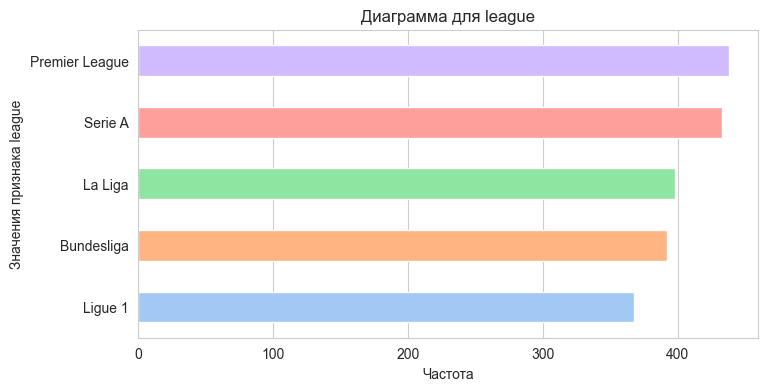

In [28]:
sns.set_style('whitegrid')
stats_countplot('league')

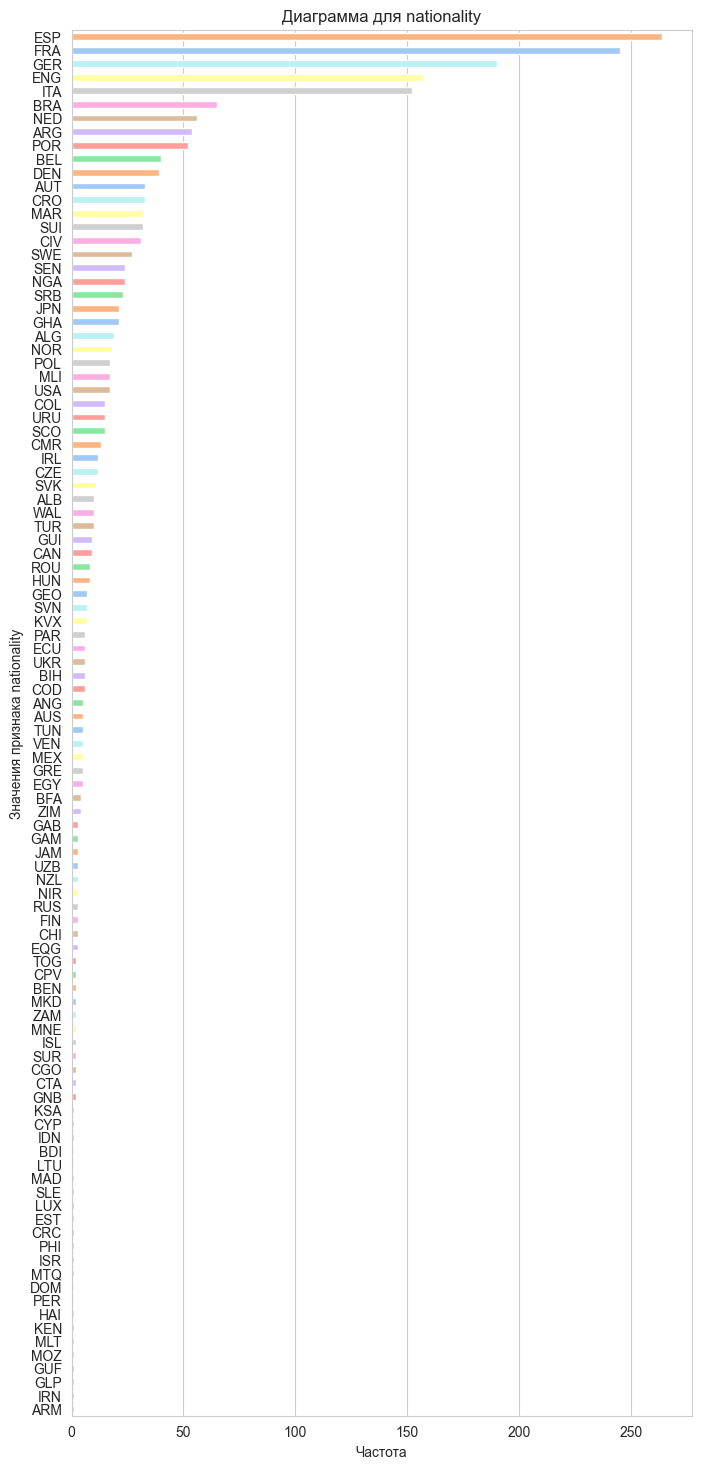

In [29]:
stats_countplot('nationality', figsize=(8, 18))

Большинство игроков из Испании, Франции, Германии, Англии и Италии, что неудивительно, так как наши данные как раз и чемпионатов этих стран.  

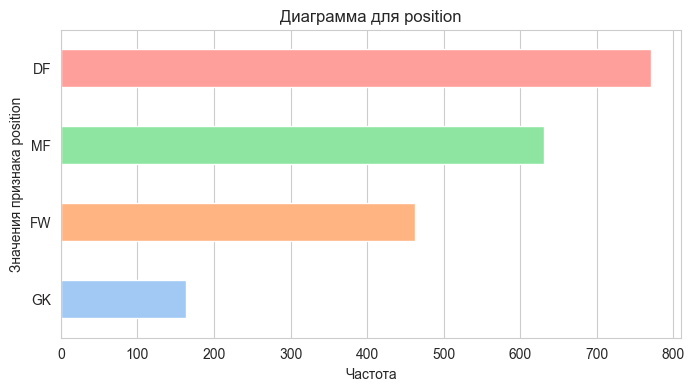

In [30]:
stats_countplot('position')

Большинство игроков из нашего датасета - это защитники, реже же всего представлены вратари.

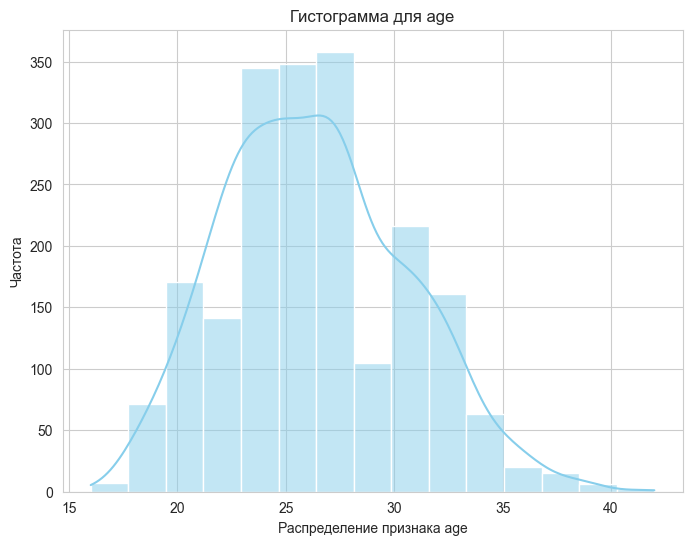

In [31]:
stats_histogram('age', bins=15)

Распределение данных о возрасте игрока имеет нормальные ввид с небольшим скосом влево.

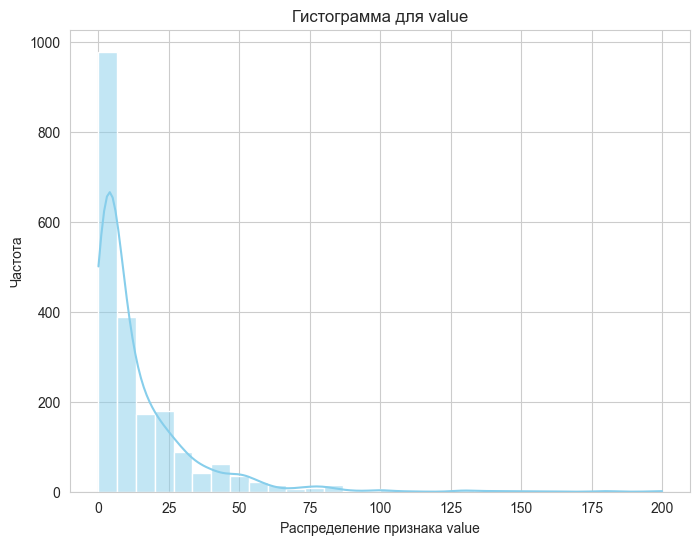

In [32]:
stats_histogram('value', bins=30)

In [33]:
df = df.query('value < 100')

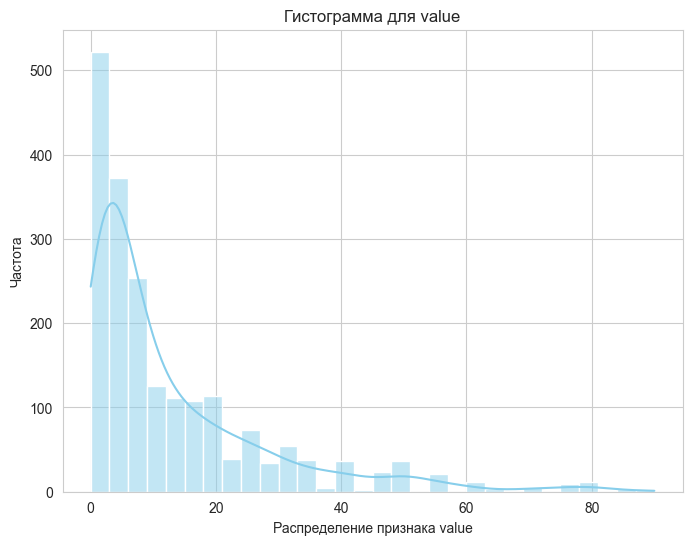

In [34]:
stats_histogram('value', bins=30)

Видим, что стоимость игроков нашего датасета имеет логнормальное распределение. Также подрежем немного "хвост" справа.

Для удобства визуализации разобьем наши признаки на подкатегории по различных статистическим футбольным аспектам и обязательно оставим данные о стоимости игрока в каждой категории.

In [35]:
basic_cols = pd.Index(df.columns[:6].tolist() + ['value']) # подкатегория базовых метрик
standart_cols = pd.Index(df.columns[6:35].tolist() + ['value']) # подкатегория основных метрик
shooting_cols = pd.Index(df.columns[35:42].tolist() + ['value']) # подкатегория метрик ударов по воротам
passing_cols = pd.Index(df.columns[42:58].tolist() + ['value']) # подкатегория метрик передач
pass_types_cols = pd.Index(df.columns[58:71].tolist() + ['value']) # подкатегория метрик типов передач
creatiom_cols = pd.Index(df.columns[71:87].tolist() + ['value']) # подкатегория метрик голевых действий
def_actions_cols = pd.Index(df.columns[87:102].tolist() + ['value']) # подкатегория оборонительных действий
possesion_actions_cols = pd.Index(df.columns[102:120].tolist() + ['value']) # подкатегория метрик при владении
playing_time_cols = pd.Index(df.columns[120:134].tolist() + ['value']) # подкатегория метрик игрового времени
miscellaneous_cols = pd.Index(df.columns[134:-1].tolist() + ['value']) # подкатегория с различными другими метриками

Для каждой подкатегории построим phik матрицу, для определения коррелирующих и мультиколлинеарных признаков. При обнаружении мульколлинеарности, удалим один из двух признаков.

In [36]:
def phik_matrixx(cols, list_of_interval_cols, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    phik_matrix = df[cols].phik_matrix(interval_cols=list_of_interval_cols)
    masking = np.triu(np.ones_like(phik_matrix, dtype=bool), k=1)
    sns.heatmap(data=phik_matrix, mask=masking, annot=True, cmap='coolwarm', fmt='.2f')
    plt.show()

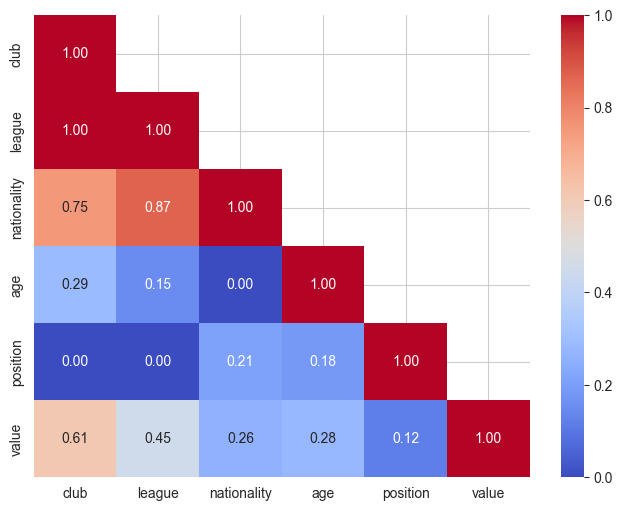

In [37]:
phik_matrixx(basic_cols.drop('player'), ['age', 'value'], figsize=(8, 6))

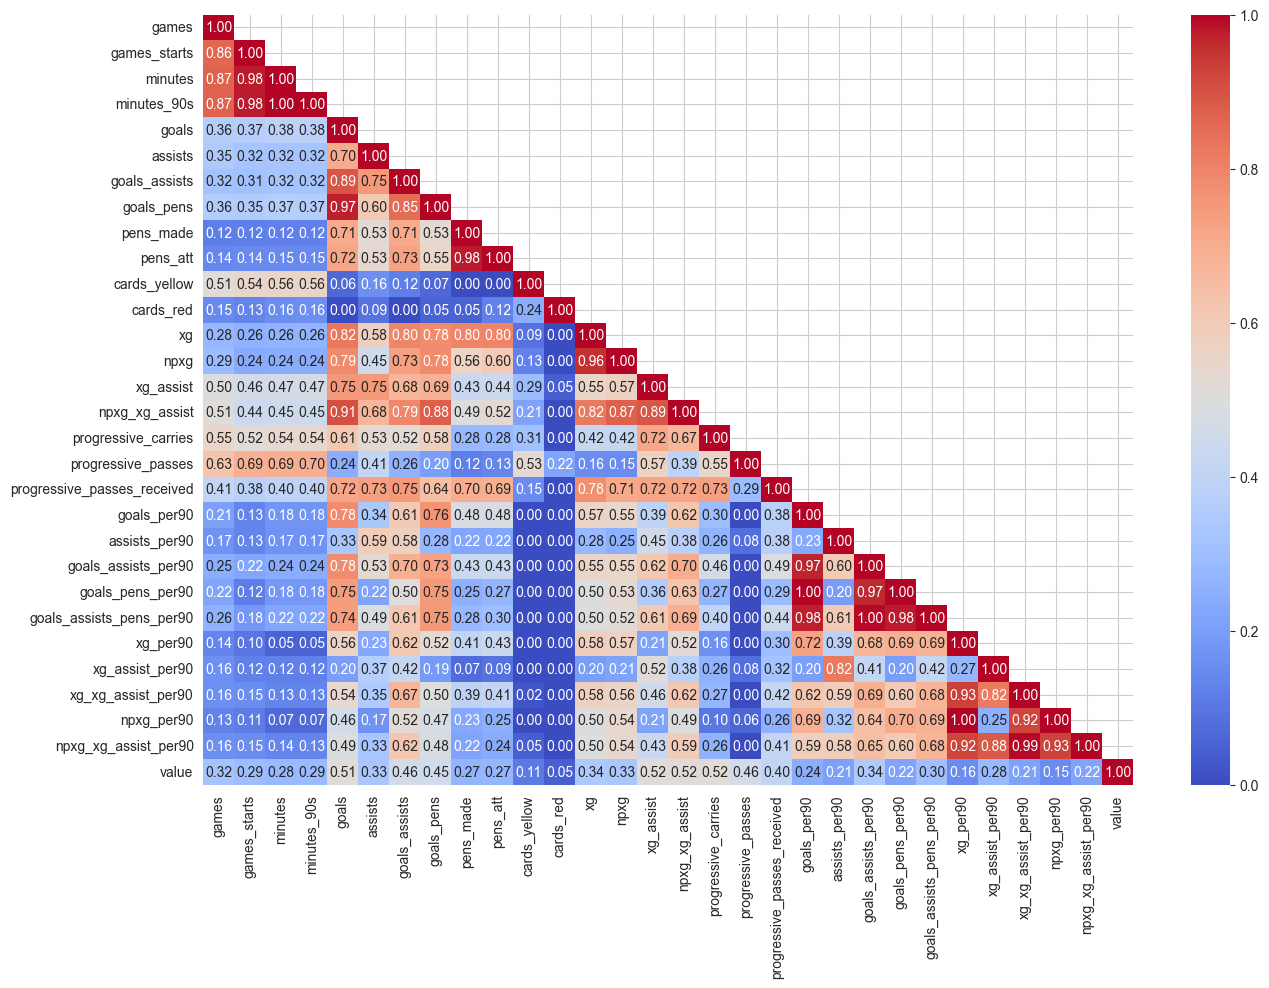

In [38]:
phik_matrixx(standart_cols, standart_cols)

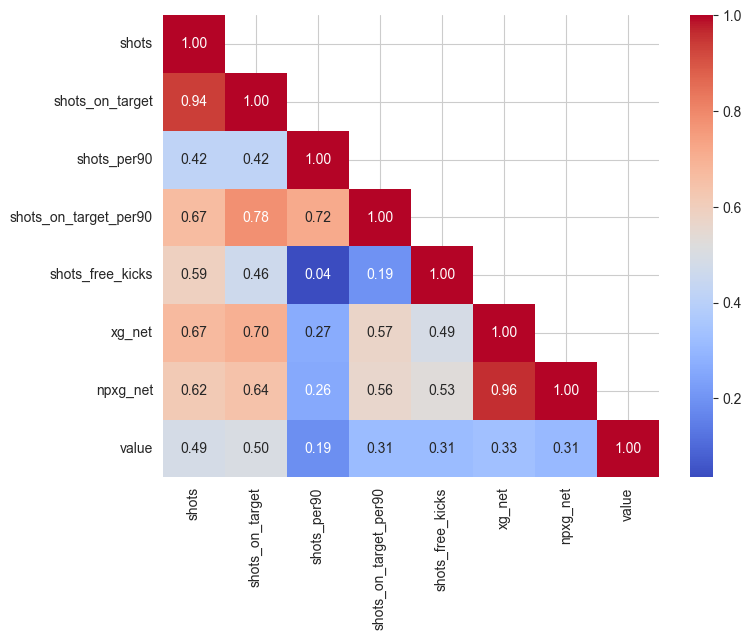

In [39]:
phik_matrixx(shooting_cols, shooting_cols, figsize=(8, 6))

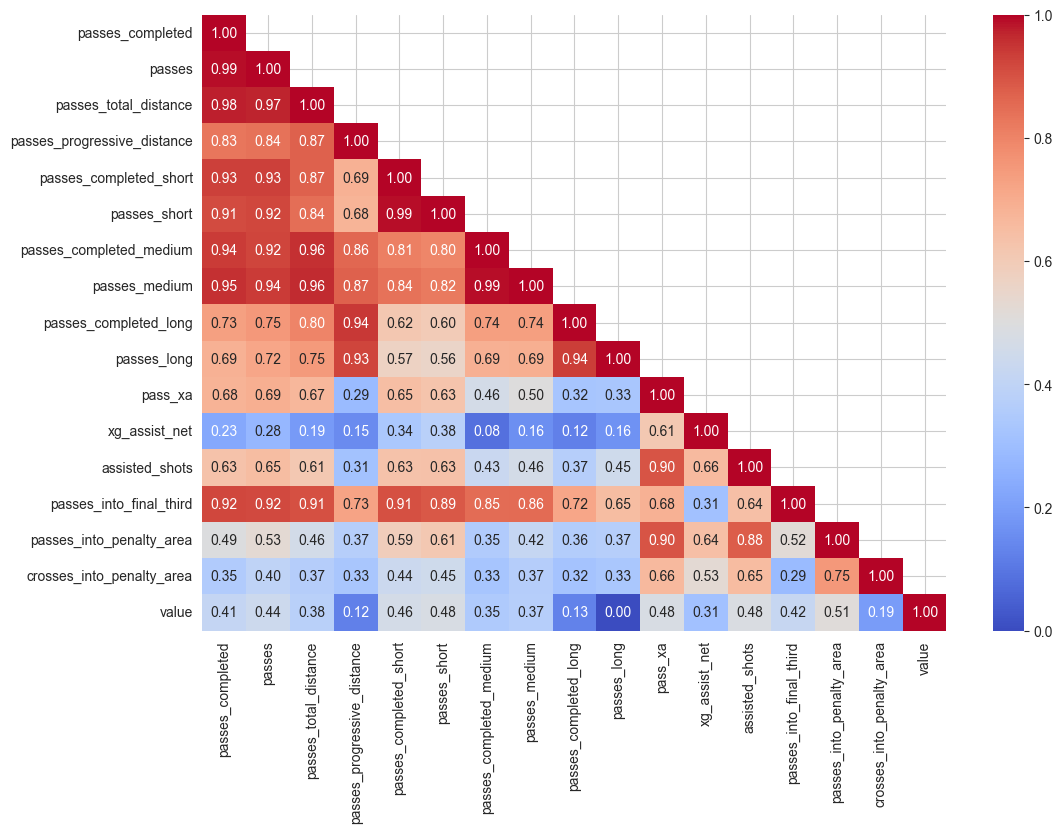

In [40]:
phik_matrixx(passing_cols, passing_cols, figsize=(12, 8))

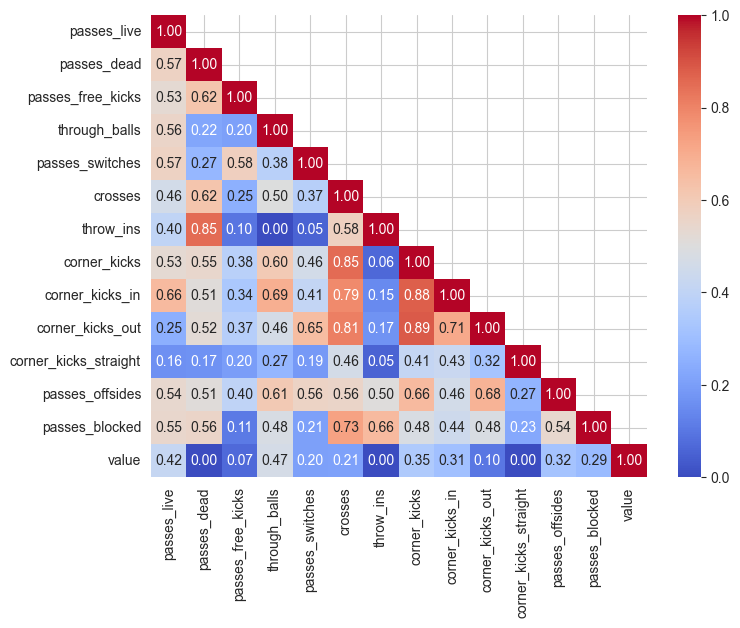

In [41]:
phik_matrixx(pass_types_cols, pass_types_cols, figsize=(8, 6))

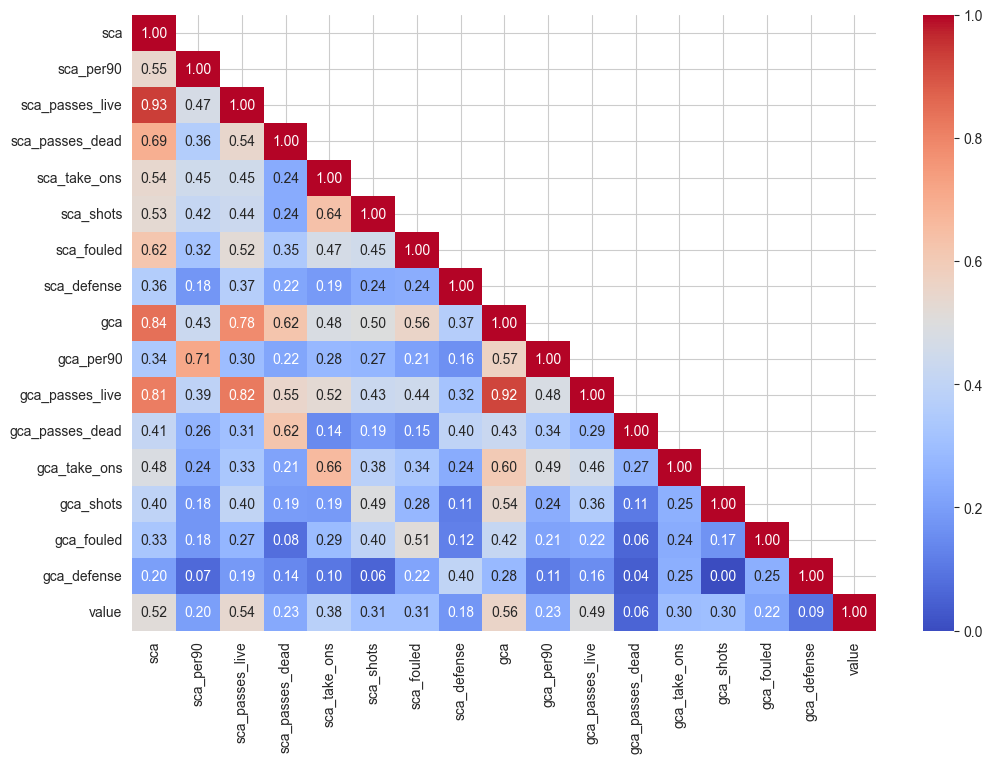

In [42]:
phik_matrixx(creatiom_cols, creatiom_cols, figsize=(12, 8))

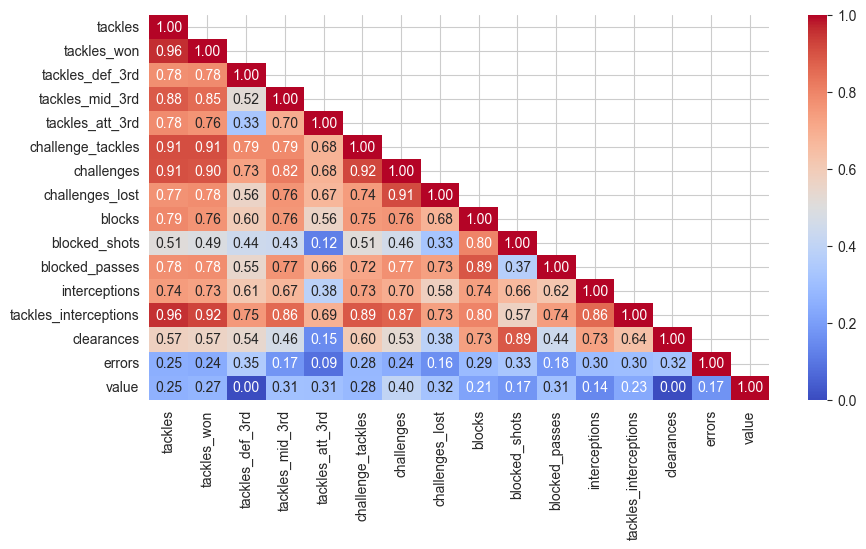

In [43]:
phik_matrixx(def_actions_cols, def_actions_cols, figsize=(10, 5))

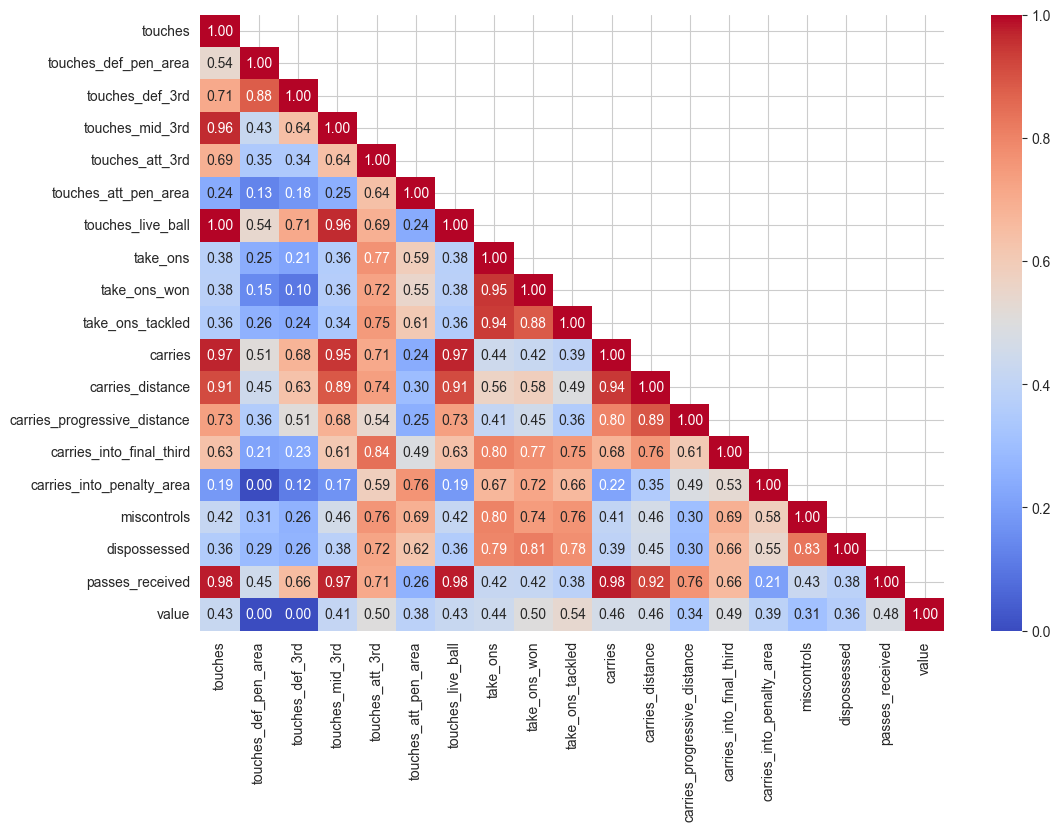

In [44]:
phik_matrixx(possesion_actions_cols, possesion_actions_cols, figsize=(12, 8))

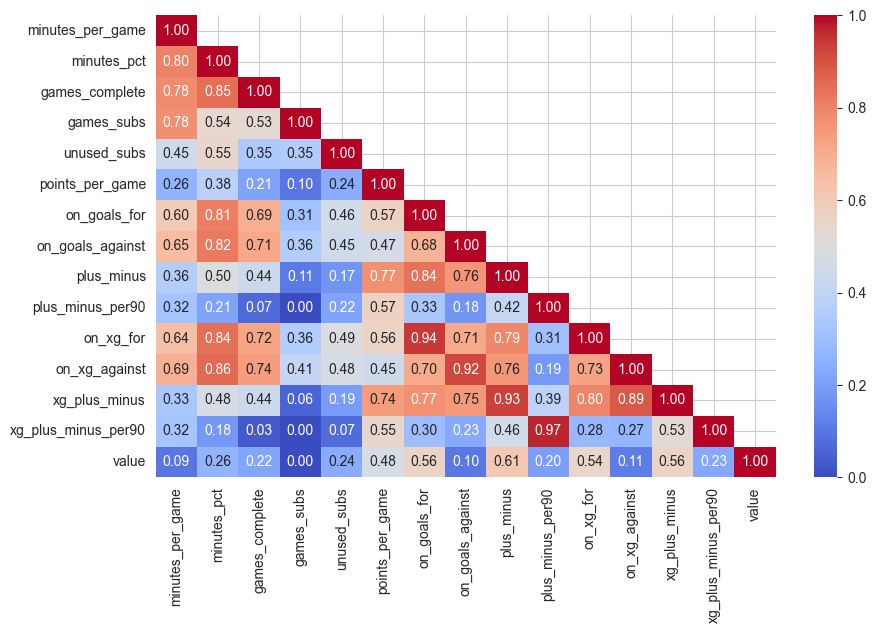

In [45]:
phik_matrixx(playing_time_cols, playing_time_cols, figsize=(10, 6))

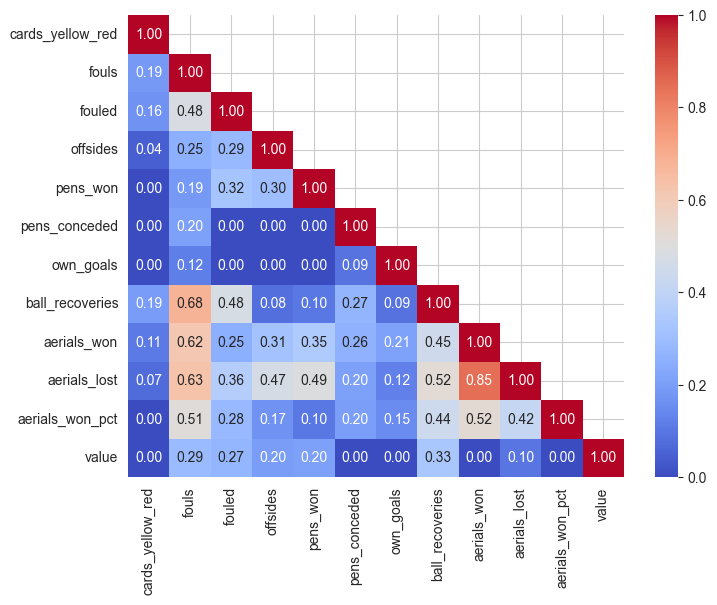

In [46]:
phik_matrixx(miscellaneous_cols, miscellaneous_cols, figsize=(8, 6))

После корреляционного анализа были выявлены признаки, слишком сильно коррелярующие с другими, и, чтобы мультиколлинеарность не повлияла на продуктивность нашей модели, избавимся от них.

In [47]:
corr_cols_to_drop = ['goals_assists', 'goals_pens', 'npxg_xg_assist', 'progressive_passes_received', 
'goals_per90', 'goals_assists_per90', 'goals_pens_per90', 'goals_assists_pens_per90',
'xg_xg_assist_per90', 'npxg_per90', 'npxg_xg_assist_per90', 'passes_completed', 'passes', 'passes_total_distance',
'passes_progressive_distance', 'passes_into_final_third', 'passes_into_penalty_area', 'passes_completed_short',
'passes_completed_medium', 'passes_completed_long', 'crosses', 'corner_kicks_out', 'throw_ins', 'gca_passes_live', 'sca',
'tackles', 'challenges', 'tackles', 'tackles_interceptions', 'blocks', 'tackles_won', 'blocked_shots', 'touches_mid_3rd',
'touches_live_ball', 'take_ons_won', 'take_ons_tackled', 'carries_distance', 'touches_att_3rd', 'touches_def_3rd',
'miscontrols', 'passes_received', 'minutes_pct', 'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
'aerials_lost']

In [48]:
df = df.drop(corr_cols_to_drop, axis=1)

Таким образом, в результате исследовательского анализа данных, были визуализированы прризнаки из подкатегории базовых и построена матрица корреляции абсолютно для всех подкатегорий данных. По результатам корреляционного анализа были выявлены признаки, от которых необходимо избавится, т.к они мультиколлинеарны с другими признаками. В результате EDA из датасета было удалено 49 признаков, они содержаться в списке corr_cols_to_drop.

## Отбор признаков

Для отбора наших признаков будем использовать пайплайн с преобработкой данных и RFECV. Для этого сначала разделим наш датасет на тренировоную и тестовую выборки. Для обучения модели нам не пригодится признак `player`, т.к все значения в нем различны, а также значение `club`. 

In [49]:
X = df.drop(['player', 'club', 'value'], axis=1)
y = df['value']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Целевую переменную стадартизируем для обучения моделей.

In [51]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [52]:
ohe_columns = ['league', 'position']

target_enc_columns = ['nationality']

num_columns = X.drop(ohe_columns + target_enc_columns, axis=1).columns

In [53]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
        ('target', TargetEncoder(target_type='continuous', random_state=RANDOM_STATE), target_enc_columns),
         ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Модель для RFECV был выбран LinearSVR т.к. он не требует больших вычислительных мощностей и LinearSVR оптимизирован для работы высокомерными пространствами.

In [54]:
feature_selection_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('rfecv', RFECV(estimator=LinearSVR(C=0.001, random_state=RANDOM_STATE),
                    cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1))
])

In [55]:
feature_selection_pipeline.fit(X_train, y_train_scaled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['league', 'position']),
                                                 ('target',
                                                  TargetEncoder(random_state=42,
                                                                target_type='continuous'),
                                                  ['nationality']),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'games', 'games_starts', 'minutes', 'minute...
       'points_per_game', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
       'xg_plus_minus_per90', 'cards_yellow_red', 'fouls', 'fouled',
       'offsides', 'pens_won', 'pens_conceded', 'own_goals', 'ball_recoveries',
       'aerials_won', 'aerials_won_pct'],
      dtype='object'))])),
                ('rfecv',
                 RFECV(cv=5, estimator=LinearSVR(C=0.001, random_state=42),
                       n_jobs=-1, scoring='neg_root_mean_squared_error'))])

In [56]:
print(feature_selection_pipeline.named_steps['rfecv'].n_features_)
rfe_mask = feature_selection_pipeline.named_steps['rfecv'].support_
selected_features = feature_selection_pipeline.named_steps['preprocessor'].get_feature_names_out()[rfe_mask]

71


Видим, что RFECV оставил 71 признак в наших данных.

In [57]:
X_train_selected = feature_selection_pipeline.transform(X_train)
X_test_selected = feature_selection_pipeline.transform(X_test)

Таким образом, на этапе отбора был использован пайплайн с предобработкой данных (кодированием и масштабированием) и RFECV для отбора самых значимых параметров. По итогам его работы был выбран 71 признак.

## Выбор и обучение модели

Выбор модели будем осуществлять с помощью кросс-валидации. В качестве моделей для кросс-валидации были использованы:
1. ElasticNet
2. KNeighborsRegressor
3. LinearSVR
4. DecisionTreeRegressor
5. LGBMRegressor
6. XGBRegressor
7. RandomForestRegressor

In [58]:
pipe_final = Pipeline([
    ('models', None)
])

Составим список словарей гиперпараметров модели.

In [59]:
param_grid = [
    
    # словарь для модели ElasticNet()
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__l1_ratio' : np.arange(0.0, 1, 0.1),
    },
    
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 10),
    },
    
    # словарь для модели LinearSVR()
    {
        'models': [LinearSVR(random_state=RANDOM_STATE)],
        'models__C': [0.01, 0.1, 1, 10],
    },

    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    },

    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(n_estimators=500, learning_rate=0.01, random_state=RANDOM_STATE)],
        'models__reg_alpha': range(0, 5, 1)
    },

    # словарь для модели XGBRegressor()
    {
        'models': [XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=RANDOM_STATE)],
        'models__reg_alpha': range(0, 5, 1)
    },

    # словарь для модели RandomForestRegressor()
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
    }
]

В качестве метрики для GridSearchCV выберем MAE.

In [60]:
gs = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=False
)
gs.fit(X_train_selected, y_train_scaled)

C:\Users\Mikhail\.conda\envs\main\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Mikhail\.conda\envs\main\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Mikhail\.conda\envs\main\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Mikhail\.conda\envs\main\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Mikhail\.conda\envs\main\Lib\subprocess.py", line 1538, in _execute_child
    h

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6344
[LightGBM] [Info] Number of data points in the train set: 1608, number of used features: 71
[LightGBM] [Info] Start training from score -0.000000


GridSearchCV(cv=5, estimator=Pipeline(steps=[('models', None)]), n_jobs=-1,
             param_grid=[{'models': [ElasticNet(random_state=42)],
                          'models__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                         {'models': [KNeighborsRegressor()],
                          'models__n_neighbors': range(2, 10)},
                         {'models': [LinearSVR(random_state=42)],
                          'models__C': [0.01, 0.1, 1, 10]},
                         {'models': [DecisionTr...
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=500, n_jobs=None,
                                                  num_parallel_tree=None, ...)],
                          'models__reg_alpha': range(0, 5)},
                         {'models': [RandomForestRegressor(random_state=42)]}],
             scoring='neg_mean_absolute_error', verbose=False)

In [61]:
print('Лучшая модель и её параметры:\n', gs.best_estimator_)
print ('\nМетрика лучшей модели при кросс-валидации:', round((np.abs(gs.best_score_) * scaler_y.scale_)[0], 3), 'млн.евро')

Лучшая модель и её параметры:
 Pipeline(steps=[('models',
                 LGBMRegressor(learning_rate=0.01, n_estimators=500,
                               random_state=42, reg_alpha=1))])

Метрика лучшей модели при кросс-валидации: 5.715 млн.евро


Таким образом, лучшей моделью для наших данных оказалась LGBMRegressor. Её итоговый показатель MAE - 5,7 млн.евро. 

## Оценка и интерпретация модели

Оценим нашу выбранную модель на тестовых данных.

In [62]:
y_pred_scaled = gs.predict(X_test_selected)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
print('Оценка на тестовых данных:')
print('   RMSE:', round(root_mean_squared_error(y_test, y_pred), 3), 'млн.евро')
print('   MAE:', round(mean_absolute_error(y_test, y_pred), 3), 'млн.евро')
print('   R2:', round(r2_score(y_test, y_pred), 3))

Оценка на тестовых данных:
   RMSE: 9.98 млн.евро
   MAE: 6.07 млн.евро
   R2: 0.624


C:\Users\Mikhail\.conda\envs\main\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Также построим графики SHAP значений для интерпретации модели.

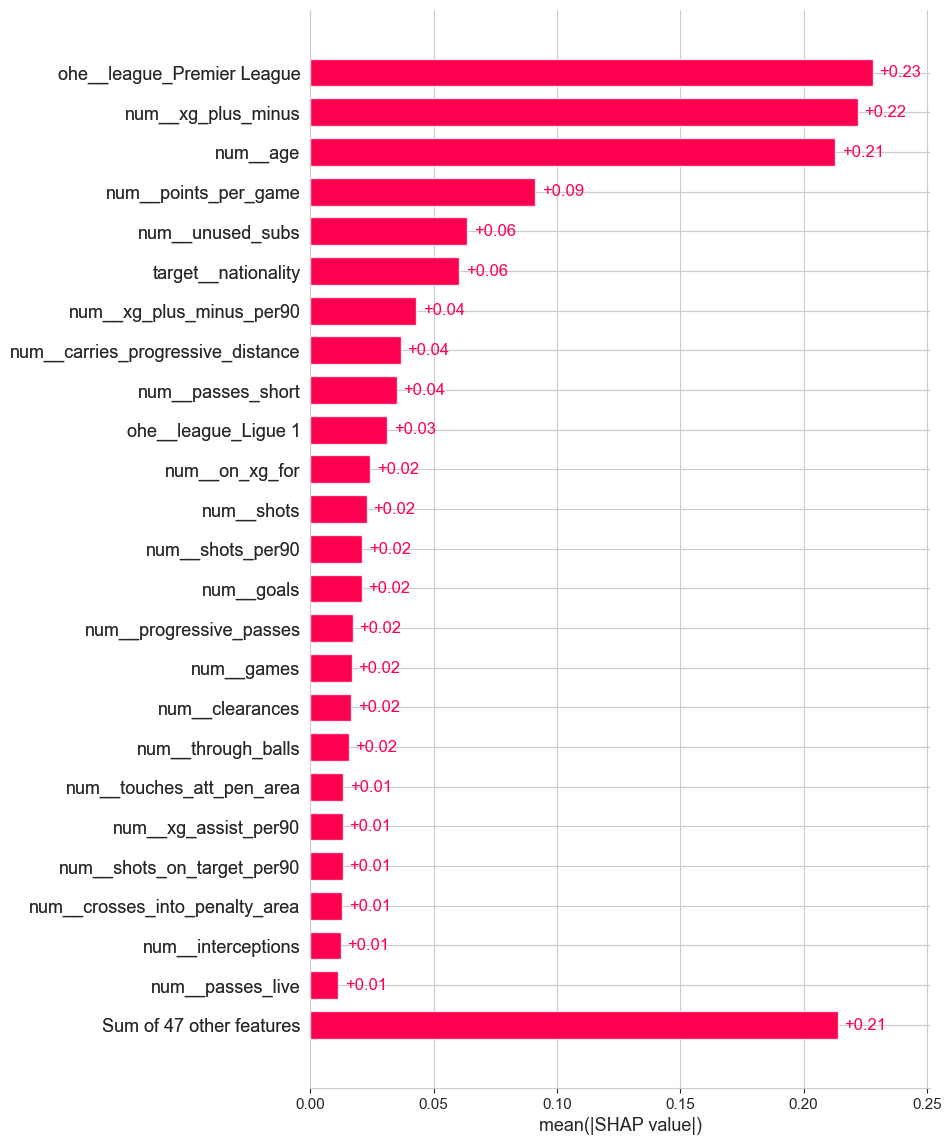

None

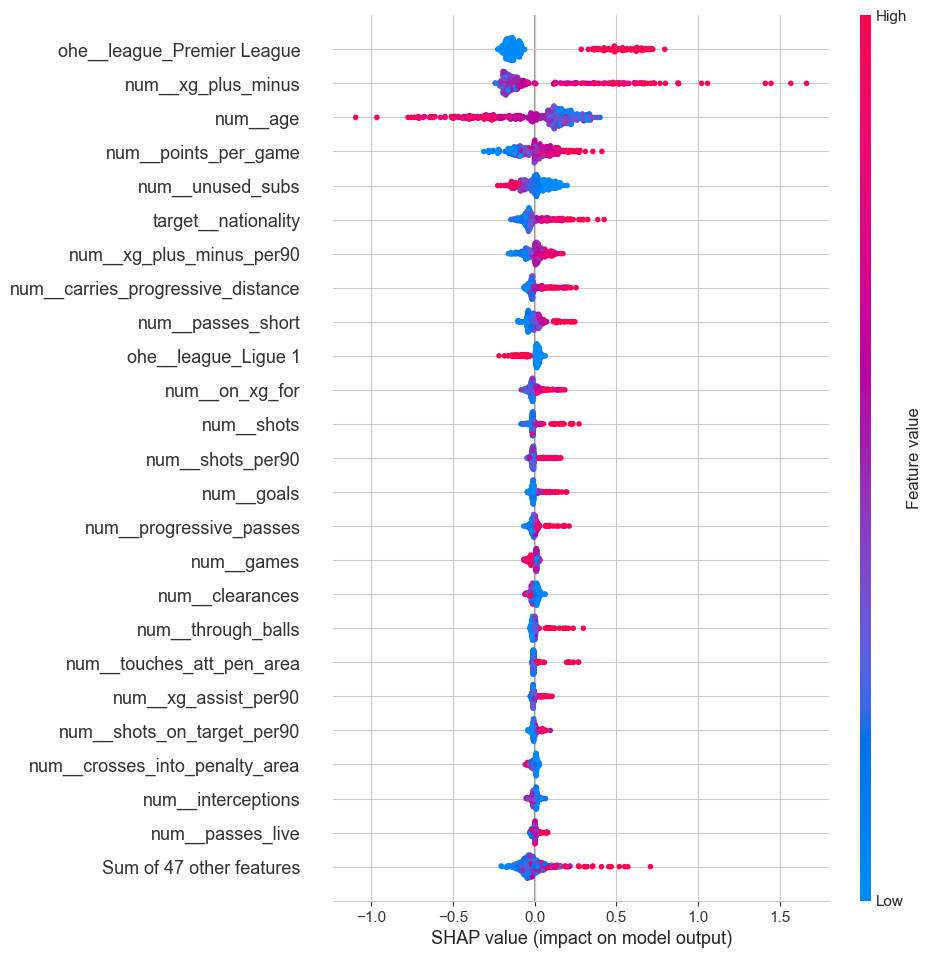

None

In [63]:
explainer = shap.TreeExplainer(gs.best_estimator_.named_steps['models'])

X_test_2 = pd.DataFrame(X_test_selected, columns=selected_features)

shap_values = explainer(X_test_2)

display(shap.plots.bar(shap_values, max_display=25))
display(shap.plots.beeswarm(shap_values, max_display=25))

- 🔎 Интересно, что больше всего в нашей модели на итоговую стоимость влияет **играет ли футболист в Английской Премьер Лиге** или нет, что имеет место и в реальной жизни, так как игроки АПЛ зачастую стоят выше рынка, так называемый "EPL tax", популярный термин в футбольном англоязычном X комьюнити.

- 📊 На втором месте по значимости для модели идет признак - **xG +/-**, что показывает важность полезности игрока по всему полю для его итоговой стоимости, а также важности хорошей команды для большей стоимости.

- 📝 На третьем месте по значимости - **возраст футболиста**, что, действительно, отражает реальность, так как клубы не готовы покупать возрастных футболистов за большие деньги из-за риска спада формы и общего физического спада после 30 лет.

Остальные признаки существенно менее значимы для модели.

<div style="border: 1px solid red; padding: 10px; border-radius: 5px;">
    
Показатели RMSE = 9.98 млн.евро, MAE = 6.07 млн.евро и R2 = 0.624 неплохие, но всё же это достаточно большие цифры для ориентации при покупке игрока. На мой взгляд, **статистические показатели - это важные и определяющие факторы для стоимости игрока, но не единственные**. Не менее важными показателями могут быть:
    
- 📸 **Медийность игрока (количество упоминаний в спортивной прессе и X, количество рекламных контрактов);**
- 📝 **Контрактные условия (игроки с истекающим контрактом стоят дешевле);**
- 🏥 **Травмы и репутация игрока.**
- 📈 **Спрос на позицию игрока на рынке и т.д.**

Поэтому для увеличения предсказательной силы модели необходимо учитывать и другие факторы, выходящие за рамки обычной футбольной статистики. Данный проект можно считать базовым для дальнейших исследований, в который в будущем можно добавлять другие различные признаки, описанные выше.
</div>

## 🔍 Выводы

В ходе работы над проектом была разработана и протестирована модель машинного обучения, способная предсказывать трансферную стоимость футболистов на основе их статистических данных, характеристик и других релевантных факторов. Основные результаты и выводы:

1. **Основные результаты**

- Наилучшей моделью оказался **LGBMRegressor** с **MAE = 5.7 млн €** (кросс-валидация) и **6.07 млн €** на тестовых данных.

- Модель объясняет **62.4% дисперсии** (R² = 0.624), что указывает на приемлемое, но не идеальное качество прогноза.

- Ключевые признаки, влияющие на стоимость:

    - **Игра в АПЛ** (+"EPL tax") — главный драйвер цены.
    
    - **xG +/-** — полезность игрока в атаке и защите.
    
    - **Возраст** — отрицательное влияние после 30 лет.

2. **Ограничения модели**

- **Высокая ошибка прогноза**: MAE ~6 млн € означает, что для топ-игроков (стоимость >50 млн €) погрешность может достигать 10-20%.

- **Упущенные факторы**:

    - Коммерческая ценность (соцсети, реклама).
    
    - Контрактные условия (срок, зарплата).
    
    - История травм и психологическая устойчивость.

- **Смещение данных**: Перекос в сторону топ-лиг (АПЛ, Ла Лига) может занижать стоимость игроков из менее популярных чемпионатов.

3. **Практическая применимость**

Модель может быть полезна для:
- ✅ **Первичной оценки** игроков скаутами.
- ✅ **Выявления недооценённых талантов** (например, игроков с высоким xG, но низкой текущей стоимостью).
- ⚠️ **Но не для точного определения цены трансфера** из-за значительной погрешности.

4. **Рекомендации по улучшению**

- **Добавить новые признаки**:

    - Медийность (упоминания в СМИ, подписчики в соцсетях).
    
    - Данные о травмах (количество пропущенных матчей).
    
    - Условия контракта (срок, релиз-клаузула).

- **Углублённый анализ ошибок**: Изучить случаи, где модель ошибается >10 млн €, чтобы выявить скрытые закономерности.

🎯 **Итоговый вердикт**

Проект успешно решает задачу **базовой оценки стоимости игроков на основе статистики**, но требует доработок для коммерческого использования. **Главные направления для развития:**

1. Интеграция **нестатистических факторов** (контракты, медийность).

2. Снижение MAE до **4-5 млн €** за счёт более богатого датасета.

3. Создание **интерактивного инструмента** (например, Dash-приложения) для визуализации прогнозов.

Проект стоит рассматривать как **первую итерацию** для более сложной системы оценки футбольных трансферов.